ile## Stage 2 Model to be run on HPC - Preditcing Bearing Cap with Length and Diam Inputs

In [7]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import torch.optim as optim
import torch.nn as nn
import torch.nn.init as init
from torch.optim.lr_scheduler import ReduceLROnPlateau


# Initialize scalers outside the dataset class
length_scaler = StandardScaler()
cptu_scaler = StandardScaler()
output_scaler = StandardScaler()

class BoreholeDataset(Dataset):
    def __init__(self, csv_file, length_scaler, cptu_scaler, output_scaler, fit_scalers=True):
        data = pd.read_csv(csv_file)
        self.length = data.iloc[:, 0].values.reshape(-1, 1)
        self.diam = data.iloc[:, 1].values.reshape(-1, 1)
        self.cptu_data = data.iloc[:, 2:6164].values
        self.outputs1 = data.iloc[:, 6164].values.reshape(-1, 1)

        if fit_scalers:
            self.length = length_scaler.fit_transform(self.length)
            self.diam = length_scaler.fit_transform(self.diam)
            self.cptu_data = cptu_scaler.fit_transform(self.cptu_data)
            self.outputs1 = output_scaler.fit_transform(self.outputs1)

        self.length = torch.tensor(self.length, dtype=torch.float32)
        self.diam = torch.tensor(self.diam, dtype=torch.float32)
        self.cptu_data = torch.tensor(self.cptu_data, dtype=torch.float32)
        self.outputs1 = torch.tensor(self.outputs1, dtype=torch.float32)

    def __len__(self):
        return len(self.outputs1)

    def __getitem__(self, idx):
        return self.length[idx], self.diam[idx], self.cptu_data[idx], self.outputs1[idx]



train_dataset = BoreholeDataset('Stage_2_traind_merged_reduced3.csv', length_scaler, cptu_scaler, output_scaler, fit_scalers=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = BoreholeDataset('Stage_2_vald_merged_reduced3.csv', length_scaler, cptu_scaler, output_scaler, fit_scalers=False)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)




       
# class TwoBranchMLP(nn.Module):
#     def __init__(self, length_features, diam_features, cptu_features, cptu_neurons, length_diam_neurons, dropout_rate=0.5):
#         super(TwoBranchMLP, self).__init__()
# 
#         # Create dynamic layers for the CPTu branch with batch normalization
#         self.cptu_branch = self.create_branch(cptu_features, cptu_neurons, dropout_rate)
# 
#         # Combined input size for Length and Diameter branch
#         combined_input_size = length_features + diam_features
#         self.length_diameter_branch = self.create_branch(combined_input_size, length_diam_neurons, dropout_rate)
# 
#         # Final output layer
#         last_cptu_neurons = cptu_neurons[-1]
#         last_length_diam_neurons = length_diam_neurons[-1]
#         self.combined = nn.Sequential(
#             nn.Linear(last_cptu_neurons + last_length_diam_neurons, max(last_cptu_neurons, last_length_diam_neurons)),
#             nn.BatchNorm1d(max(last_cptu_neurons, last_length_diam_neurons)),
#             nn.LeakyReLU(0.01),
#             nn.Linear(max(last_cptu_neurons, last_length_diam_neurons), 1)
#         )
# 
#     def create_branch(self, input_features, neurons, dropout_rate):
#         layers = []
#         for i in range(len(neurons)):
#             if i == 0:
#                 layers.append(nn.Linear(input_features, neurons[i]))
#             else:
#                 layers.append(nn.Linear(neurons[i-1], neurons[i]))
#             layers.extend([
#                 nn.BatchNorm1d(neurons[i]),
#                 nn.LeakyReLU(0.01),
#                 nn.Dropout(dropout_rate)
#             ])
#         return nn.Sequential(*layers)
# 
#     def forward(self, length_data, diam_data, cptu_data):
#         cptu_out = self.cptu_branch(cptu_data)
#         combined_input = torch.cat((length_data, diam_data), dim=1)
#         input_out = self.length_diameter_branch(combined_input)
#         combined_out = torch.cat((cptu_out, input_out), dim=1)
#         output = self.combined(combined_out)
#         return output
# 
# 
# def initialize_weights(m):
#     if isinstance(m, nn.Linear):
#         init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
#         if m.bias is not None:
#             init.constant_(m.bias, 0)





import torch
from torch import nn
from torch.nn import init

class TwoBranchMLP(nn.Module):
    def __init__(self, length_features, diam_features, cptu_features, neurons, layers, dropout_rate=0.5):
        super(TwoBranchMLP, self).__init__()

        # Create dynamic layers for the CPTu branch and Length-Diameter branch using the same architecture
        self.cptu_branch = self.create_branch(cptu_features, neurons, layers, dropout_rate)
        combined_input_size = length_features + diam_features
        self.length_diameter_branch = self.create_branch(combined_input_size, neurons, layers, dropout_rate)

        # Final output layer combining outputs from two branches
        self.combined = nn.Sequential(
            nn.Linear(2 * neurons[-1], neurons[-1]),
            nn.BatchNorm1d(neurons[-1]),
            nn.Tanh(),
            nn.Linear(neurons[-1], 1)
        )

    def create_branch(self, input_features, neurons, layers, dropout_rate):
        modules = []
        current_features = input_features
        for i in range(layers):
            modules.append(nn.Linear(current_features, neurons[i]))
            modules.append(nn.BatchNorm1d(neurons[i]))
            modules.append(nn.Tanh())
            modules.append(nn.Dropout(dropout_rate))
            current_features = neurons[i]
        return nn.Sequential(*modules)

    def forward(self, length_data, diam_data, cptu_data):
        cptu_out = self.cptu_branch(cptu_data)
        combined_input = torch.cat((length_data, diam_data), dim=1)
        length_diam_out = self.length_diameter_branch(combined_input)
        combined_out = torch.cat((cptu_out, length_diam_out), dim=1)
        output = self.combined(combined_out)
        return output

def initialize_weights(m):
    if isinstance(m, nn.Linear):
        # Xavier normal initialization is typically used for Tanh activation
        init.xavier_normal_(m.weight)
        if m.bias is not None:
            init.constant_(m.bias, 0)

# Example instantiation and weight initialization
neurons = [32, 32, 32]  # Example neuron configuration
layers = 3  # Assuming 4 layers as per the length of neurons list
model = TwoBranchMLP(1, 1, 6162, neurons, layers, 0.1)
model.apply(initialize_weights)  # Apply the weight initialization method

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()



def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)
    
    model.train()
    loss_history = []
    val_loss_history = []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for batch_idx, (length_data, diam_data, cptu_data, targets) in enumerate(train_loader):
            
            optimizer.zero_grad()
            outputs = model(length_data, diam_data, cptu_data)
            loss = criterion(outputs, targets)
            # print("Loss:", loss.item())  # This will confirm loss is calculated
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
        
        average_train_loss = total_train_loss / len(train_loader)
        loss_history.append(average_train_loss)

        # Validation phase
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for length_data, diam_data, cptu_data, targets in val_loader:
                
                outputs = model(length_data, diam_data, cptu_data)
                val_loss = criterion(outputs, targets)
                total_val_loss += val_loss.item()

        average_val_loss = total_val_loss / len(val_loader)
        val_loss_history.append(average_val_loss)
        
        scheduler.step(average_val_loss)
        
    return loss_history, val_loss_history


loss_history1 = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=1)
print(loss_history1)

# torch.save(model.state_dict(), "S2_model2.pth")
# 
# with open('S2_loss2.txt', 'w') as file:
#     for item in loss_history1:
#         file.write(f"{item}\n")

# from joblib import dump
# dump((length_scaler, cptu_scaler, output_scaler), 'S2_scalers.joblib')

KeyboardInterrupt: 

## Stage 2 - Evaluating Loss Values from HPC

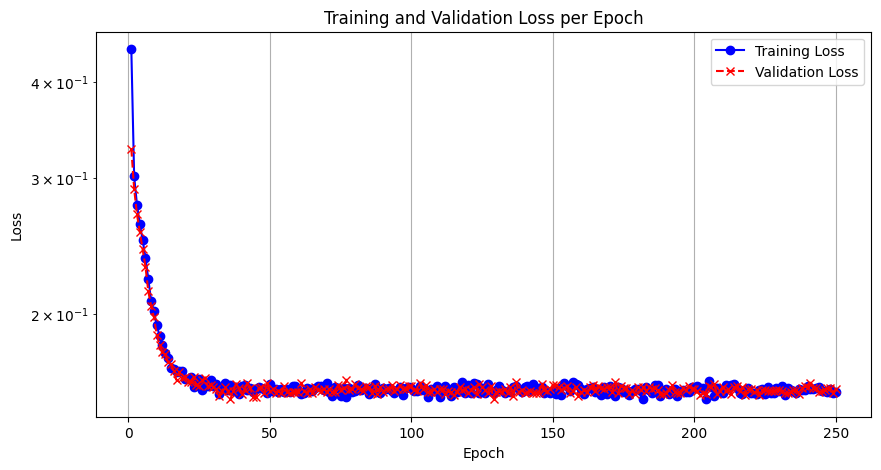

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Path to the text file
file_path = 'S2_loss21.txt'

# Read the entire file into a single string
with open(file_path, 'r') as file:
    line = file.readline().strip()

# Remove the brackets and split the string into a list of numbers
cleaned_line = line.strip('[]')
numbers = list(map(float, cleaned_line.split(',')))

# Assuming alternate entries for training and validation losses
train_losses = numbers[0::2]  # Extract even index elements: training losses
val_losses = numbers[1::2]  # Extract odd index elements: validation losses

# Epochs array based on the shorter of the two lists
epochs = np.arange(1, min(len(train_losses), len(val_losses)) + 1)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, marker='o', linestyle='-', color='blue', label='Training Loss')
plt.plot(epochs, val_losses, marker='x', linestyle='--', color='red', label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()


## Evaluating Model - Calculating Correlation Coefficients and Plotting Graphs

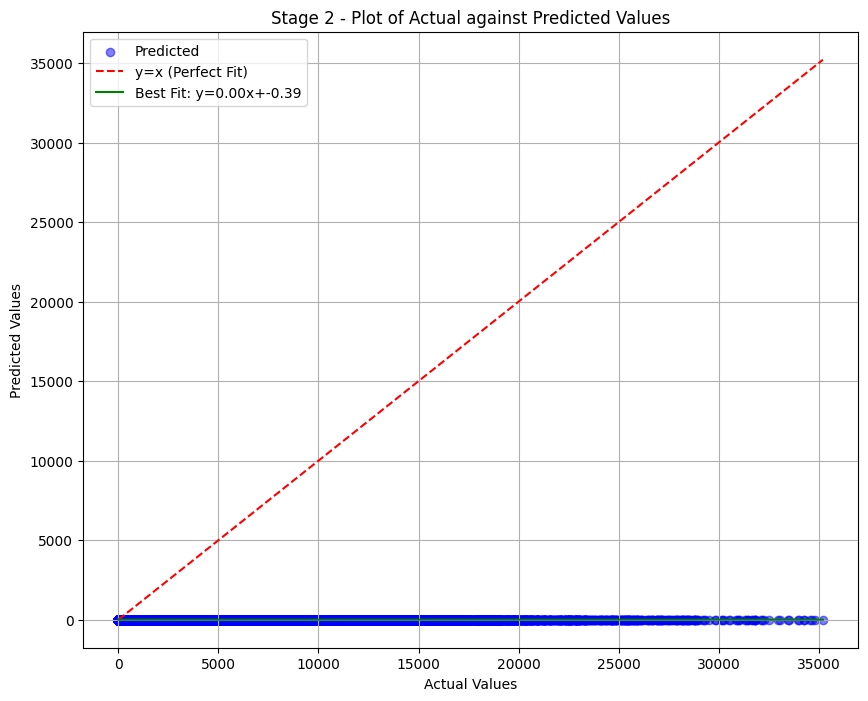

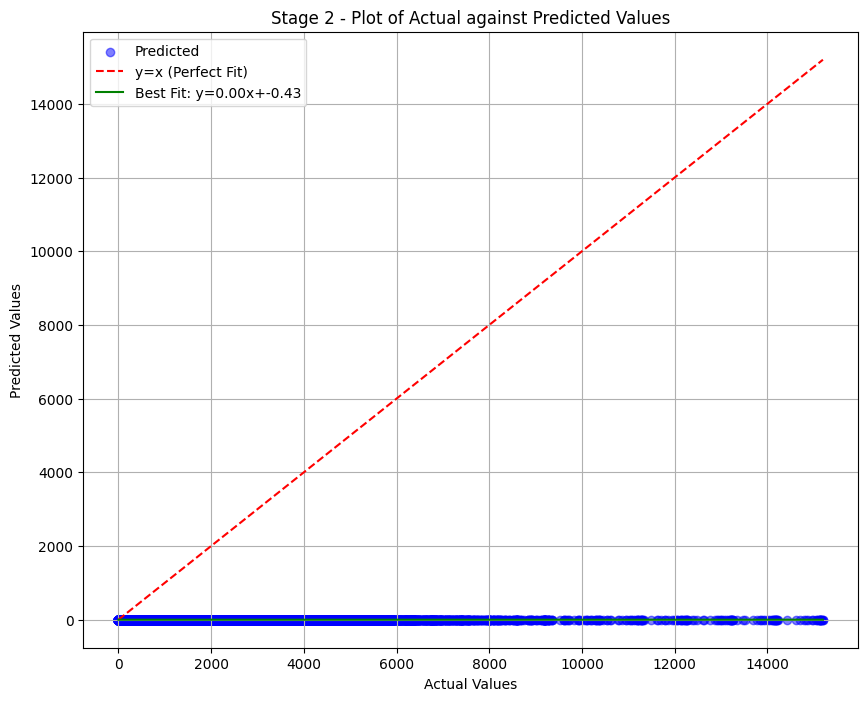

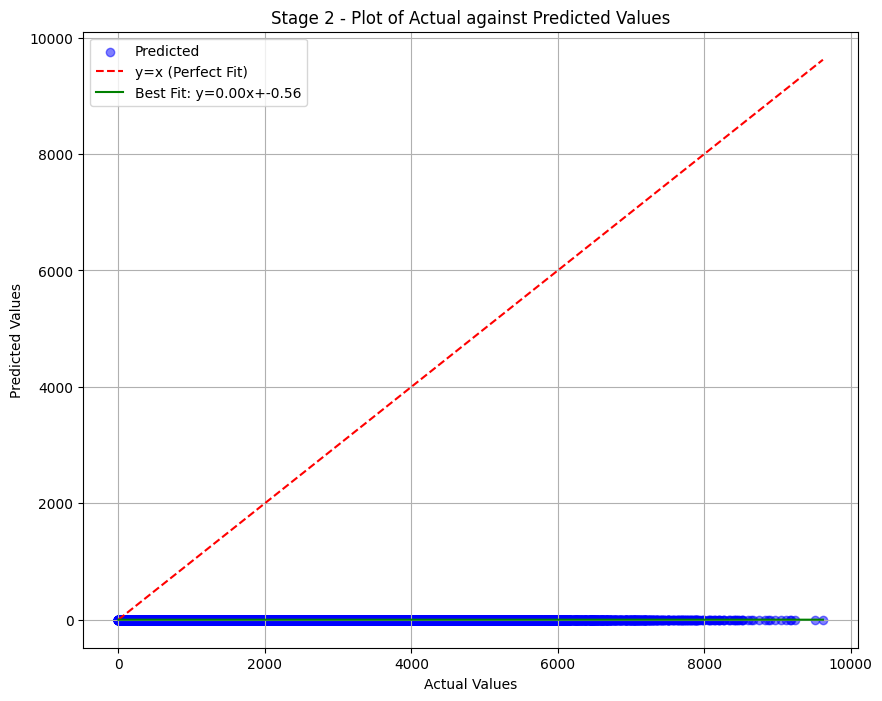

Training MSE: 8741217.6925, R²: 0.4165, Relative Error: 250.1063
Validation MSE: 3935141.6548, R²: 0.0090, Relative Error: 182.4685
Testing MSE: 2886050.7204, R²: 0.0679, Relative Error: 354.4950


In [6]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score, mean_squared_error
from joblib import load

# Load model and scalers
# model = YourModelClass()  # Ensure to define your model class correctly
model.load_state_dict(torch.load('S2_model21.pth'))
model.eval()

length_scaler, cptu_scaler, output_scaler = load('S2_scalers21.joblib')

def process_data(csv_file, length_scaler, cptu_scaler, output_scaler):
    data = pd.read_csv(csv_file)
    input1 = torch.tensor(length_scaler.transform(data.iloc[:, 0].values.reshape(-1, 1)), dtype=torch.float32)
    input2 = torch.tensor(length_scaler.transform(data.iloc[:, 1].values.reshape(-1, 1)), dtype=torch.float32)
    CPTu = torch.tensor(cptu_scaler.transform(data.iloc[:, 2:6164].values), dtype=torch.float32)
    targets = torch.tensor(output_scaler.transform(data.iloc[:, 6164].values.reshape(-1, 1)), dtype=torch.float32)
    return DataLoader(TensorDataset(input1, input2, CPTu, targets), batch_size=64, shuffle=False)



# Load your datasets
train_loader = process_data('Stage_2_traind_merged_reduced3.csv', length_scaler, cptu_scaler, output_scaler)
val_loader = process_data('Stage_2_vald_merged_reduced3.csv', length_scaler, cptu_scaler, output_scaler)
test_loader = process_data('Stage_2_testd_merged_reduced3.csv', length_scaler, cptu_scaler, output_scaler)



def plot_actual_vs_predicted(filename, actuals, predictions, title='Actual vs. Predicted', actual_scaler=None, prediction_scaler=None):
    # If scalers are provided, inverse transform the data
    if actual_scaler is not None:
        actuals = actual_scaler.inverse_transform(actuals.reshape(-1, 1)).flatten()
    if prediction_scaler is not None:
        predictions = prediction_scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()

    # Flatten arrays to ensure they are 1D
    actuals = actuals.flatten()
    predictions = predictions.flatten()

    # Create a scatter plot of actual vs predicted values
    plt.figure(figsize=(10, 8))
    plt.scatter(actuals, predictions, alpha=0.5, color='blue', label='Predicted')

    # Plot the identity line
    max_val = max(max(actuals), max(predictions))
    min_val = min(min(actuals), min(predictions))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y=x (Perfect Fit)')

    # Calculate the line of best fit
    coefficients = np.polyfit(actuals, predictions, 1)
    polynomial = np.poly1d(coefficients)
    trendline = polynomial(np.linspace(min_val, max_val, 100))
    plt.plot(np.linspace(min_val, max_val, 100), trendline, 'g-', label=f'Best Fit: y={coefficients[0]:.2f}x+{coefficients[1]:.2f}')

    # Add labels and legend
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Stage 2 - Plot of Actual against Predicted Values')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{filename}.png', dpi=300)
    plt.show()
    
    

def evaluate_model(filename, data_loader, output_scaler):
    total_mse = 0
    total_samples = 0
    preds, actuals = [], []
    relative_errors = []

    with torch.no_grad():
        for input1, input2, CPTu, targets in data_loader:
            outputs = model( input1, input2, CPTu)

            # Inverse transform the outputs and targets for MSE calculation only
            outputs_rescaled = output_scaler.inverse_transform(outputs.numpy())
            targets_rescaled = output_scaler.inverse_transform(targets.numpy())

            # Compute MSE on rescaled data
            mse = mean_squared_error(targets_rescaled, outputs_rescaled)
            total_mse += mse * input1.size(0)
            total_samples += input1.size(0)

            preds.append(outputs)
            actuals.append(targets)

            # Compute relative error on scaled data
            relative_error = np.abs((targets.numpy() - outputs.numpy()) / targets.numpy())
            valid_relative_error = relative_error[~np.isinf(relative_error)]
            relative_errors.extend(valid_relative_error)

    all_preds = torch.cat(preds).numpy()
    all_actuals = torch.cat(actuals).numpy()
    
    plot_actual_vs_predicted(filename, all_actuals, all_preds, output_scaler, output_scaler)
    
    # Calculate total MSE
    total_mse /= total_samples
    
    # Calculate R² score on scaled data
    r2 = r2_score(all_actuals, all_preds)

    # Calculate mean relative error on scaled data
    mean_relative_error = np.mean(relative_errors) if len(relative_errors) > 0 else np.inf

    return total_mse, r2, mean_relative_error

# Evaluate the model using separate scaling for MSE
train_mse, train_r2, train_rel_error = evaluate_model('S2_Training_data_pred_plot', train_loader, output_scaler)
val_mse, val_r2, val_rel_error = evaluate_model('S2_Validating_data_pred_plot', val_loader, output_scaler)
test_mse, test_r2, test_rel_error = evaluate_model('S2_Testing_data_pred_plot', test_loader, output_scaler)

print(f"Training MSE: {train_mse:.4f}, R²: {train_r2:.4f}, Relative Error: {train_rel_error*100:.4f}")
print(f"Validation MSE: {val_mse:.4f}, R²: {val_r2:.4f}, Relative Error: {val_rel_error*100:.4f}")
print(f"Testing MSE: {test_mse:.4f}, R²: {test_r2:.4f}, Relative Error: {test_rel_error*100:.4f}")


# To access the final model weights after evaluation:
final_weights = model.state_dict()  # This dictionary holds all weights
# You can save these weights or print t


## Plotting Graphs of Actual Fluctuations of Bearing Cap vs Pile Depth - Training Dataset

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the CSV file
df = pd.read_csv('Stage_2_traind_merged_reduced3.csv', header=None, low_memory=False)


print(np.shape(df))
# Convert columns to numeric, coercing errors to NaN
df = df.apply(pd.to_numeric, errors='coerce')

# Constants
diameters_per_length = 15  # There are 15 different diameter settings
boreholes_per_diameter = 16  # Each diameter setting has data for 3 boreholes
total_length_blocks = 309  # There are 309 length measurements per diameter
rows_per_borehole = 4635   # Total rows per borehole

# Define colors for each borehole for clarity in the plots
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 
          'olive', 'cyan', 'magenta', 'yellow', 'black', 'lime', 'teal', 'navy']
colors *= ((boreholes_per_diameter // len(colors)) + 1)  # Ensure enough colors
colors = colors[:boreholes_per_diameter]  # Trim the list to the needed number

starting_diameter = 0.2  # Starting diameter in meters

# Loop through each diameter setting
for diam_index in range(diameters_per_length):
    plt.figure(figsize=(12, 8))  # Create a new figure for each diameter
    current_diameter = starting_diameter + diam_index * 0.1

    # Iterate over each borehole in the current diameter setting
    for borehole_index in range(boreholes_per_diameter):
        # Calculate the start row index for the current borehole within the current diameter
        start_row = borehole_index * rows_per_borehole + diam_index * total_length_blocks
        end_row = start_row + total_length_blocks

        # Extracting data for this borehole within the current diameter setting
        borehole_data = df.iloc[start_row+1:end_row, :]

        # Ensure the first point starts at (0,0) and plot independently
        x_values = borehole_data.iloc[:, 0].tolist()
        y_values = borehole_data.iloc[:, 6164].tolist()  # Assuming column 6164 is the output

        # Plot using line plot
        plt.plot(x_values, y_values, color=colors[borehole_index], label=f'Borehole {borehole_index + 1}')

    plt.xlabel('Pile Length (m)')
    plt.ylabel('Pile Bearing Capacity (kN)')
    plt.title(f'Stage 2 - Training Data Pile Length vs Bearing Capacity for Diameter of {current_diameter:.1f} m')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.xlim(left=0)  # Start X-axis from 0
    plt.ylim(bottom=0)  # Ensure y-axis starts from 0


    # Save each figure with a unique name
    plt.savefig(f'Stage_2_Train_Data_plot_{diam_index + 1}_diameter_{current_diameter:.1f}_metres_check.png', dpi=300)
    plt.close()  # Close the plot to free up memory


(74161, 6165)


## Plotting Graphs of Actual Fluctuations of Bearing Cap vs Pile Depth - Validating and Testing Dataset

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the CSV files
df_val = pd.read_csv('Stage_2_vald_merged_reduced3.csv', header=None, low_memory=False)
df_test = pd.read_csv('Stage_2_testd_merged_reduced3.csv', header=None, low_memory=False)

# Convert columns to numeric, coercing errors to NaN
df_val = df_val.apply(pd.to_numeric, errors='coerce')
df_test = df_test.apply(pd.to_numeric, errors='coerce')

# Constants
diameters_per_length = 15  # There are 15 different diameter settings
boreholes_per_diameter = 3  # Adjusted number of boreholes
total_length_blocks = 309  # There are 309 length measurements per diameter
rows_per_borehole = 4635   # Total rows per borehole, assuming it's the same as before

# Loop through each diameter setting
for diam_index in range(diameters_per_length):
    plt.figure(figsize=(12, 8))  # Create a new figure for each diameter
    current_diameter = 0.2 + diam_index * 0.1  # Starting diameter in meters

    # Iterate over each borehole in the current diameter setting
    for borehole_index in range(boreholes_per_diameter):
        # Calculate the start row index for the current borehole within the current diameter
        start_row = borehole_index * rows_per_borehole + diam_index * total_length_blocks
        end_row = start_row + total_length_blocks

        # Extracting validation data for this borehole within the current diameter setting
        borehole_data_val = df_val.iloc[start_row+1:end_row, :]
        x_values_val = borehole_data_val.iloc[:, 0].tolist()
        y_values_val = borehole_data_val.iloc[:, 6164].tolist()  # Assuming column 6164 is the output

        # Plot validation data using green color
        plt.plot(x_values_val, y_values_val, color='green', label=f'Val Borehole {borehole_index + 1}')

        # Extracting test data for this borehole within the current diameter setting
        borehole_data_test = df_test.iloc[start_row+1:end_row, :]
        x_values_test = borehole_data_test.iloc[:, 0].tolist()
        y_values_test = borehole_data_test.iloc[:, 6164].tolist()  # Assuming column 6164 is the output

        # Plot test data using red color
        plt.plot(x_values_test, y_values_test, color='red', label=f'Test Borehole {borehole_index + 1}')

    plt.xlabel('Pile Length (m)')
    plt.ylabel('Pile Bearing Capacity (kN)')
    plt.title(f'Pile Length vs Bearing Capacity for Diameter {current_diameter:.1f} m')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.xlim(left=0)  # Start X-axis from 0
    plt.ylim(bottom=0)  # Ensure y-axis starts from 0

    # Save each figure with a unique name
    plt.savefig(f'S2_Combined_Data_plot_{diam_index + 1}_diameter_{current_diameter:.1f}_metres.png', dpi=300)
    plt.close()  # Close the plot to free up memory
